1. Loading and previewing GDNat Data

In [2]:
# import necessary libraries 
import xarray as xr
import os 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
# set file paths 

data_dir_cullen = os.path.join(
  "/global",
  "scratch",
  "users",
  "cmolitor",
)

data_dir_gdnat = os.path.join(
  data_dir_cullen,
  "global_suicide"
)

gdnat_1 = os.path.join(
  data_dir_gdnat, 
  "climate_data",
  "gdnat_ACCESS-CM2_tas_1979-1999_v2025-02-11.zarr", 
)

gdnat_2 = os.path.join(
  data_dir_gdnat, 
  "geographic_data",
  "gdnat_ACCESS-CM2_tas_1979-1999_v2025-02-11.zarr", 
)

data_dir_era5 = "/global/scratch/users/yougsanghvi"  

# List files in the directory to verify 

dir_toverify = gdnat_2

try:
    files = os.listdir(dir_toverify)
    print(f"Files in {dir_toverify}:")
    for file in files:
        print(file)
except FileNotFoundError:
    print(f"Directory not found: {dir_toverify}")
except PermissionError:
    print(f"Permission denied to access: {dir_toverify}")



Files in /global/scratch/users/cmolitor/global_suicide:
geographic_data
climate_data


In [4]:
# load data
gdnat_data = xr.open_zarr(gdnat_1)

# view the data
# gdnat_data
gdnat_data.values

<bound method Mapping.values of <xarray.Dataset> Size: 32GB
Dimensions:  (lat: 720, lon: 1440, model: 1, time: 7665)
Coordinates:
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * model    (model) object 8B 'ACCESS-CM2'
  * time     (time) object 61kB 1979-01-01 00:00:00 ... 1999-12-31 00:00:00
Data variables:
    tas      (model, time, lat, lon) float32 32GB dask.array<chunksize=(1, 365, 100, 100), meta=np.ndarray>
Attributes:
    Created by:     Robert Fofrich <robertfofrich@ucla.edu>
    Creation date:  Compiled ZARR store created and saved 2025-02-11 01:39:52...
    Description:    GDNat: a global, daily, high-resolution natural-forcing o...
    Method:         Use Quantile Delta Mapping to apply quantile-by-quantile ...
    Repo:           https://github.com/ClimateImpactLab/gdnat
    Source files:   gs://impactlab-data/climate/attribution/outputs/hist-nat-...>

In [ ]:
# preview the data - see all timestamps between a range to confirm frequency

"""
# Define the time range
start_date = "1979-09-01"
end_date = "1979-09-03"

# Extract and print timestamps within that range
timestamps_in_range = gdnat_data.sel(time=slice(start_date, end_date)).time.values
print("Timestamps in range:")
for t in timestamps_in_range:
    print(t)

# preview the data for one timeframe 

# Select one timestamp to preview tas values
snapshot = gdnat_data['tas'].sel(time='1979-09-02T00:00:00')

# Convert to table format
df_snapshot = snapshot.squeeze().to_dataframe().reset_index()
print("\nSnapshot of tas values on 1979-09-02:")
print(df_snapshot.head(10))
"""


Timestamps in range:
1979-09-01 00:00:00
1979-09-02 00:00:00
1979-09-03 00:00:00

Snapshot of tas values on 1979-09-02:
    lat   lon       model                 time         tas
0 -90.0  0.00  ACCESS-CM2  1979-09-02 00:00:00  226.296738
1 -90.0  0.25  ACCESS-CM2  1979-09-02 00:00:00  226.296738
2 -90.0  0.50  ACCESS-CM2  1979-09-02 00:00:00  226.296738
3 -90.0  0.75  ACCESS-CM2  1979-09-02 00:00:00  226.296738
4 -90.0  1.00  ACCESS-CM2  1979-09-02 00:00:00  226.296738
5 -90.0  1.25  ACCESS-CM2  1979-09-02 00:00:00  226.296738
6 -90.0  1.50  ACCESS-CM2  1979-09-02 00:00:00  226.296738
7 -90.0  1.75  ACCESS-CM2  1979-09-02 00:00:00  226.296738
8 -90.0  2.00  ACCESS-CM2  1979-09-02 00:00:00  226.296738
9 -90.0  2.25  ACCESS-CM2  1979-09-02 00:00:00  226.296738


2. Comparitive exploration of GDNat and ERA5 Data

ERA5 shape: (721, 1440)
GDNat shape: (720, 1440)
ERA5 dims: ('latitude', 'longitude')
GDNat dims: ('lat', 'lon')


In [ ]:
# Set your time range for comparison
start_date = "1995-01-01"
end_date = "2005-12-31"

# Load ERA5 daily data (merge across years if needed)

era5_files = [f"{data_dir_era5}/era5_daily_mean_{year}.nc" for year in range(1995, 2006)]

print("loading ERA5 files")
era5_ds = xr.open_mfdataset(
    era5_files,
    combine='by_coords',
    decode_timedelta=True,
    chunks={'time': 365}
)

print("finished ERA5 loading files")

# Select time range
print("slicing both files")
era5_sel = era5_ds.sel(time=slice(start_date, end_date))
gdnat_sel = gdnat_data.sel(time=slice(start_date, end_date))
print("finished slicing files")

# Ensure temperature units are comparable (ERA5 is in Kelvin, GDNat usually too)
print("converting to celsius")
era5_temp = era5_sel['t2m'] - 273.15  # Convert to °C
gdnat_temp = gdnat_sel['tas'].squeeze() - 273.15  # Remove 'model' dim
print("finished converting to celsius")

# Time-average both
print("computing means")
era5_mean = era5_temp.mean(dim='time').compute()
gdnat_mean = gdnat_temp.mean(dim='time').compute()
print("finished computing means")

# ensure alignment for merging 
gdnat_mean = gdnat_mean.rename({'lat': 'latitude', 'lon': 'longitude'})

print("ERA5 shape:", era5_mean.shape)
print("GDNat shape:", gdnat_mean.shape)
print("ERA5 dims:", era5_mean.dims)
print("GDNat dims:", gdnat_mean.dims)

# Delta (Panel F)
delta = era5_mean - gdnat_mean

loading ERA5 files
finished ERA5 loading files
slicing both files
finished slicing files
converting to celsius
finished converting to celsius
computing means
finished computing means
ERA5 shape: (721, 1440)
GDNat shape: (720, 1440)
ERA5 dims: ('latitude', 'longitude')
GDNat dims: ('latitude', 'longitude')


In [22]:
# previewing the resulting mean files

# era5_mean.values
# era5_mean

gdnat_mean


<xarray.DataArray 'tas' (latitude: 720, longitude: 1440)> Size: 4MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(720, 1440), dtype=float32)
Coordinates:
  * latitude   (latitude) float64 6kB -90.0 -89.75 -89.5 ... 89.25 89.5 89.75
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    model      <U10 40B 'ACCESS-CM2'

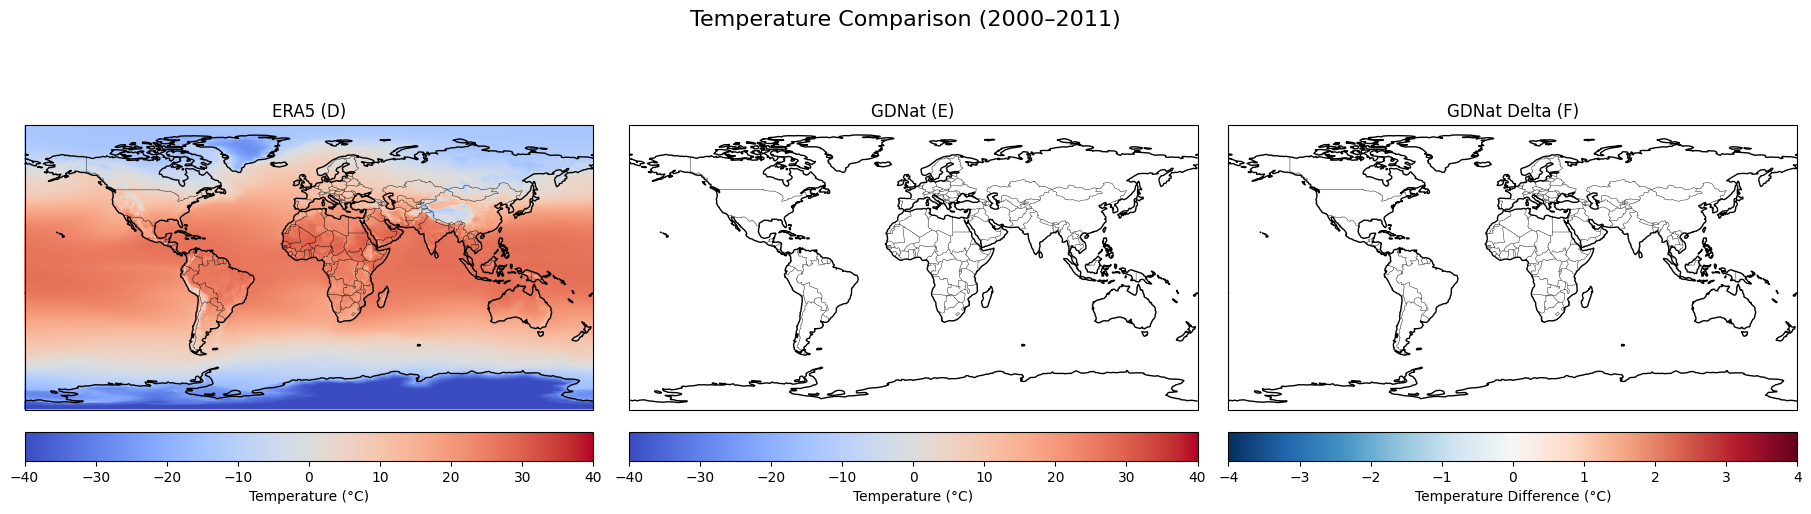

In [15]:

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 5), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

# Panel D: ERA5
im1 = axs[0].pcolormesh(era5_mean['longitude'], era5_mean['latitude'], era5_mean,
                        cmap='coolwarm', vmin=-40, vmax=40, transform=ccrs.PlateCarree())
axs[0].set_title("ERA5 (D)")
axs[0].coastlines()
axs[0].add_feature(cfeature.BORDERS, linewidth=0.3)
plt.colorbar(im1, ax=axs[0], orientation='horizontal', label='Temperature (°C)')

# Panel E: GDNat
im2 = axs[1].pcolormesh(gdnat_mean['longitude'], gdnat_mean['latitude'], gdnat_mean,
                        cmap='coolwarm', vmin=-40, vmax=40, transform=ccrs.PlateCarree())
axs[1].set_title("GDNat (E)")
axs[1].coastlines()
axs[1].add_feature(cfeature.BORDERS, linewidth=0.3)
plt.colorbar(im2, ax=axs[1], orientation='horizontal', label='Temperature (°C)')

# Panel F: Delta
im3 = axs[2].pcolormesh(delta['longitude'], delta['latitude'], delta,
                        cmap='RdBu_r', vmin=-4, vmax=4, transform=ccrs.PlateCarree())
axs[2].set_title("GDNat Delta (F)")
axs[2].coastlines()
axs[2].add_feature(cfeature.BORDERS, linewidth=0.3)
plt.colorbar(im3, ax=axs[2], orientation='horizontal', label='Temperature Difference (°C)')

plt.suptitle("Temperature Comparison (2000–2011)", fontsize=16)
plt.show()
